# Setup

In [67]:
import torch

if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  running_on_colab = True
else:
  print('Not running on Colab')
  running_on_colab = False

if running_on_colab:
    print(torch.__version__)
    !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q git+https://github.com/snap-stanford/deepsnap.git
    !pip install pyarrow
    !pip install fastparquet

    from google.colab import drive
    drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/GCNN/'
    data_folder = filepath+"graph_data/"
    models_folder = filepath+"models/"
    experiments_folder = filepath+"experiments/"

else:
    data_folder = "../../data/processed/graph_data_nohubs/"
    models_folder = "../../data/models/"
    experiments_folder = "../../data/experiments/design_space_experiment/"

Not running on Colab


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import plotly.express as px

# Utility

In [69]:
def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

def load_data(folder_path,load_test = False):
    if load_test:
        names = ["train","validation","test"]
    else:
        names = ["train","validation"]
    datasets = []
    for name in names:
        path = folder_path+name+".pt"
        datasets.append(torch.load(path))
    
    return datasets

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

def plot_training_stats(title, train_losses,val_losses, train_metric,val_metric,metric_str):

  fig, ax = plt.subplots(figsize=(8,5))
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel(metric_str)
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(train_losses, "b-", label="training loss")
  p2, = ax2.plot(val_metric, "r-", label=f"val {metric_str}")
  p3, = ax2.plot(train_metric, "o-", label=f"train {metric_str}")
  p4, = ax.plot(val_losses,"b--",label=f"validation loss")
  plt.legend(handles=[p1, p2, p3,p4],loc=2)
  plt.show()

# Load data

In [70]:
results = pd.read_parquet(experiments_folder+"experiment_18_04_23.parquet")
# node_data = load_node_csv(data_folder+"nohub_graph_nodes.csv","node_index","node_type")
# train_data, val_data = load_data(data_folder+"split_dataset/")

# Explore results

In [135]:
df = results[['L2_norm','batch_norm', 'conv_type', 'feature_dim', 'feature_type', 'hidden_channels',
       'layer_connectivity', 'macro_aggregation', 'micro_aggregation',
       'msg_passing_layers', 'post_process_layers',
       'pre_process_layers', 'auc']]
df["conv_type"] = df.conv_type.apply(lambda x: x.split(".")[-1].rstrip("\'>"))


/tmp/ipykernel_5054/989659274.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
df.sort_values(by="auc",ascending=False)

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
34,True,True,SAGEConv,10,ones,32,None,sum,sum,2,1,1,0.905190
31,True,True,SAGEConv,10,ones,32,None,mean,sum,2,1,1,0.904059
37,True,True,SAGEConv,10,ones,32,None,max,sum,2,1,1,0.896024
10,True,True,SAGEConv,10,random,32,None,max,sum,2,1,1,0.893822
7,True,True,SAGEConv,10,random,32,None,sum,sum,2,1,1,0.893822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,True,True,SAGEConv,10,random,32,None,mean,mean,3,2,1,0.726818
2,True,True,SAGEConv,10,random,128,None,mean,mean,2,1,1,0.717355
55,True,True,SAGEConv,10,random,32,None,mean,mean,2,0,2,0.713784
46,True,True,SAGEConv,10,random,32,None,mean,mean,1,0,2,0.683014


In [197]:
experiments = {
    "hidden_dim" : {
        "hidden_channels":[32,64,128],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean"],
        "macro_aggregation":["mean"],
        "layer_connectivity":[None],
        "L2_norm":[True],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10],
        "feature_type":["random"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "aggregations_conv_type" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv","GATConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean","sum","max"],
        "macro_aggregation":["mean","sum","max"],
        "layer_connectivity":[None],
        "L2_norm":[True],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10],
        "feature_type":["random"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "aggregations_feature_type" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean","sum","max"],
        "macro_aggregation":["mean","sum","max"],
        "layer_connectivity":[None],
        "L2_norm":[True],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10],
        "feature_type":["random","ones"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "connectivity" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean"],
        "macro_aggregation":["mean"],
        "layer_connectivity":[None,"skipcat","skipsum"],
        "L2_norm":[True],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10],
        "feature_type":["random"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "L2_norm" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean"],
        "macro_aggregation":["mean"],
        "layer_connectivity":[None],
        "L2_norm":[True,False],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10],
        "feature_type":["random"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "num_layers" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean"],
        "macro_aggregation":["mean"],
        "layer_connectivity":[None],
        "L2_norm":[True],
        "pre_process_layers":[0,1,2],
        "msg_passing_layers":[1,2,3],
        "post_process_layers":[0,1,2],
        "feature_dim":[10],
        "feature_type":["random"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    },

    "feature_dim" : {
        "hidden_channels":[32],
        "conv_type":["SAGEConv"],
        "batch_norm": [True],
        "dropout":[0.1],
        "activation":[torch.nn.LeakyReLU],
        "micro_aggregation":["mean"],
        "macro_aggregation":["mean"],
        "layer_connectivity":[None],
        "L2_norm":[True],
        "pre_process_layers":[1],
        "msg_passing_layers":[2],
        "post_process_layers":[1],
        "feature_dim":[10,50,100],
        "feature_type":["random","ones"],
        'weight_decay': [1e-3],
        'lr': [0.001],
        'epochs':[400],
        "patience":[5],
        "delta":[0.01]
    }
}


#TODO: delete this monstrosity
experiments = {key:np.prod([len(item) for item in exp.values()]) for key,exp in experiments.items()}

def get_range(previous_range,len_current):
    last_i = previous_range[-1]
    new_i = last_i+1+len_current
    new_range = [*range(last_i+1,new_i)]

    return new_range

def make_experiment_dict(exp_dict):
    experiment_dict = {}
    previous_range = [-1]
    for key,num in exp_dict.items():
        current_range = get_range(previous_range,num)
        experiment_dict[key] = current_range
        previous_range = current_range
    experiment_dict[list(experiment_dict.keys())[-1]].pop()
    
    return experiment_dict

experiment_index = make_experiment_dict(experiments)

In [137]:
def show_results(param,experiment_index=experiment_index,df=df):
    display(df.loc[experiment_index[param]].sort_values(by="auc",ascending=False).round(3))
    for experiment in experiment_index[param]:
        plot_training_stats(f"Experiment {experiment}", *results.loc[experiment,"curve_data"],"auc")

In [198]:
experiment_index

{'hidden_dim': [0, 1, 2],
 'aggregations_conv_type': [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'aggregations_feature_type': [21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 'connectivity': [39, 40, 41],
 'L2_norm': [42, 43],
 'num_layers': [44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70],
 'feature_dim': [71, 72, 73, 74, 75]}

## Hidden dim

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
3,True,True,SAGEConv,10,random,32,None,mean,mean,2,1,1,0.858
1,True,True,SAGEConv,10,random,64,None,mean,mean,2,1,1,0.840
2,True,True,SAGEConv,10,random,128,None,mean,mean,2,1,1,0.717


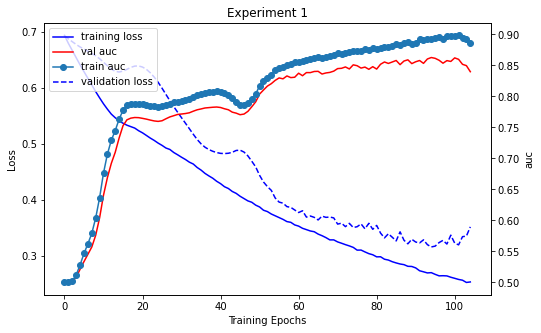

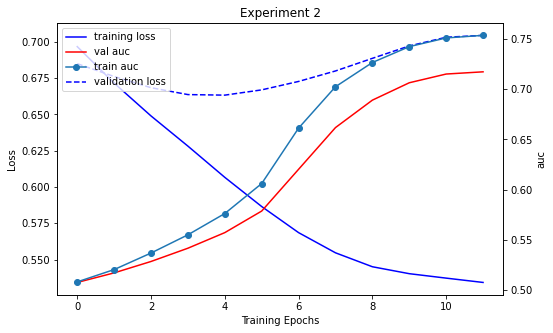

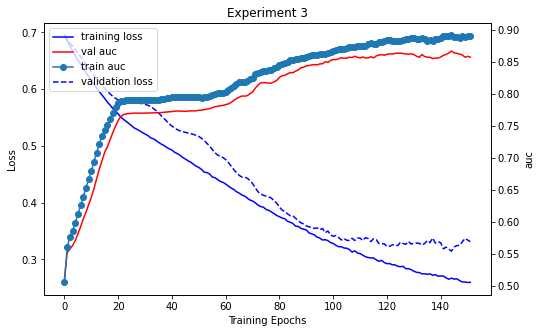

In [199]:
show_results("hidden_dim")

## Conv type and aggregations

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
10,True,True,SAGEConv,10,random,32,None,max,sum,2,1,1,0.894
7,True,True,SAGEConv,10,random,32,None,sum,sum,2,1,1,0.894
4,True,True,SAGEConv,10,random,32,None,mean,sum,2,1,1,0.894
11,True,True,SAGEConv,10,random,32,None,max,max,2,1,1,0.890
5,True,True,SAGEConv,10,random,32,None,mean,max,2,1,1,0.887
8,True,True,SAGEConv,10,random,32,None,sum,max,2,1,1,0.886
9,True,True,SAGEConv,10,random,32,None,max,mean,2,1,1,0.865
19,True,True,GATConv,10,random,32,None,max,sum,2,1,1,0.858
6,True,True,SAGEConv,10,random,32,None,sum,mean,2,1,1,0.858
18,True,True,GATConv,10,random,32,None,max,mean,2,1,1,0.827


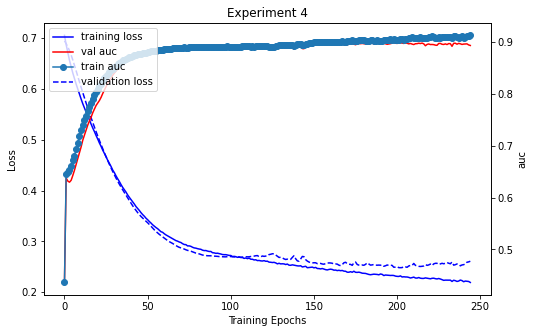

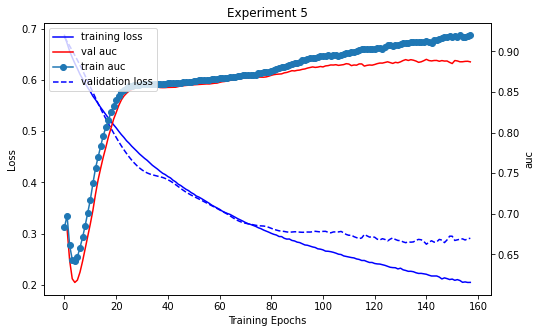

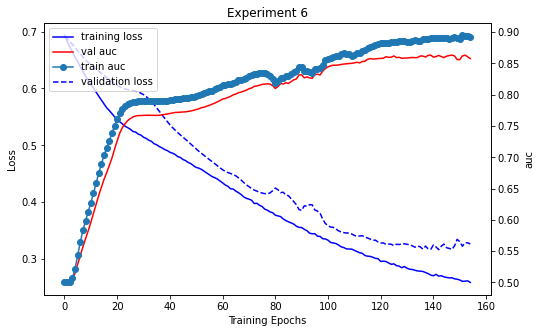

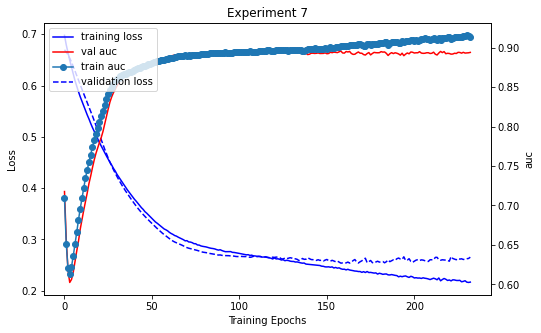

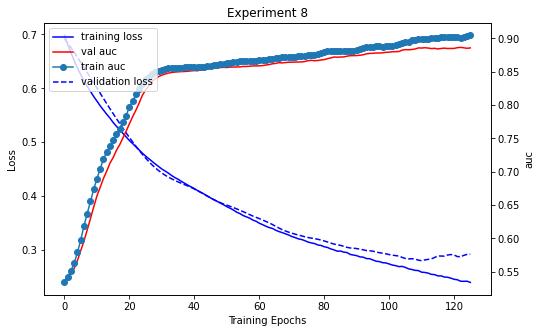

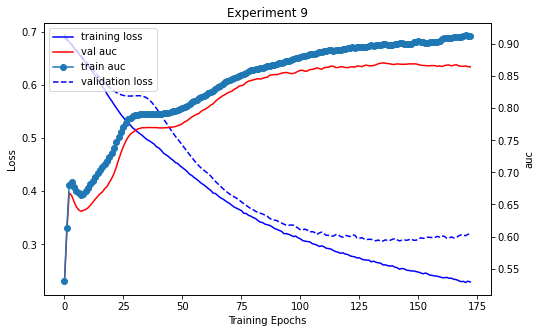

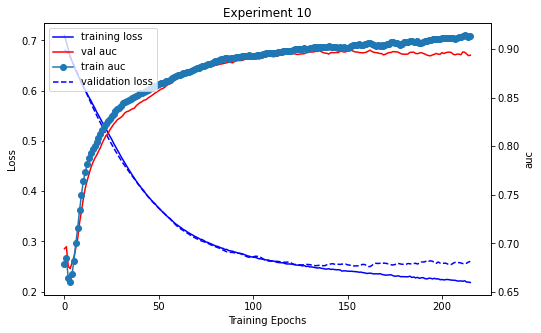

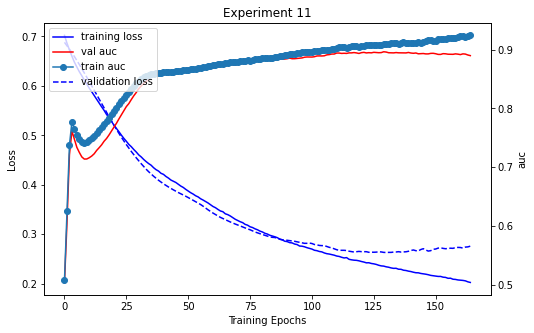

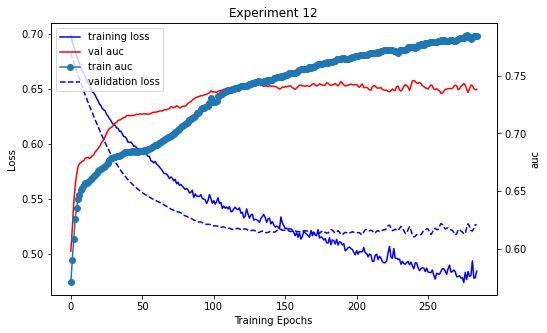

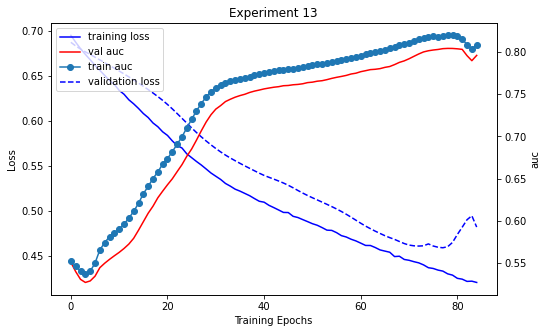

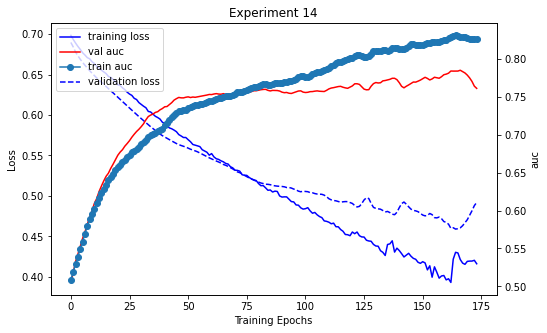

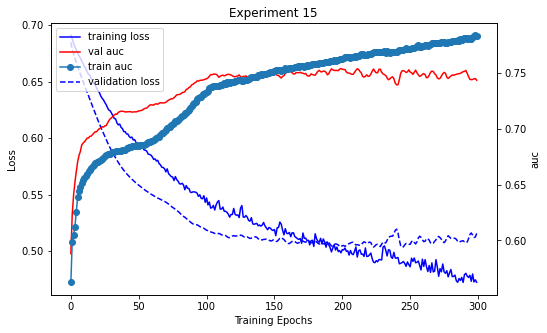

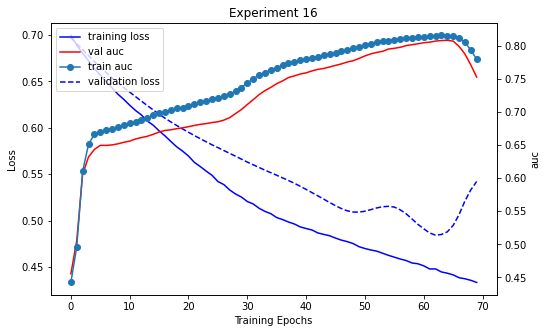

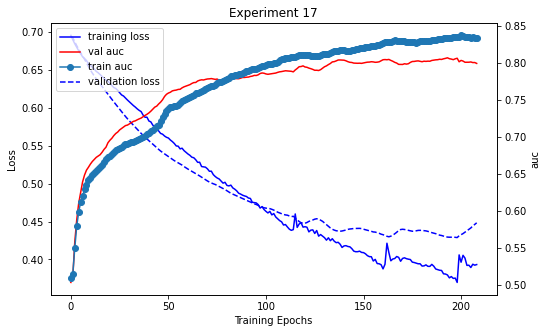

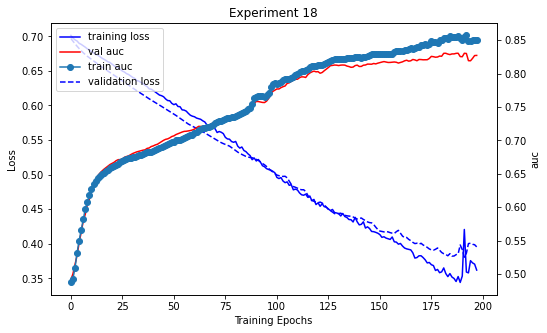

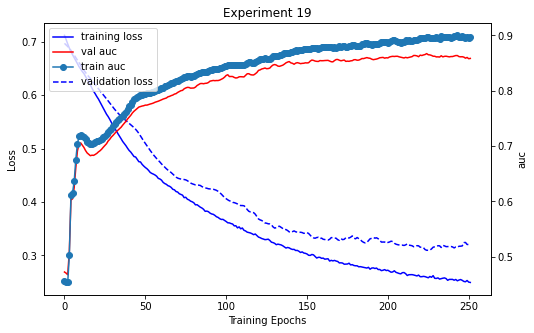

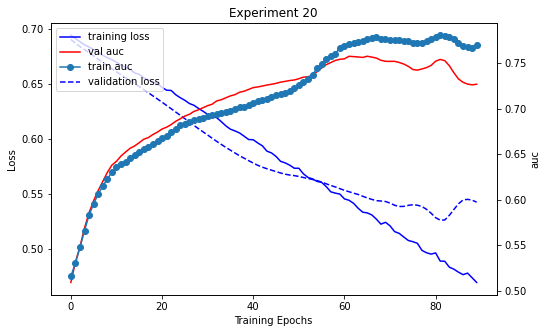

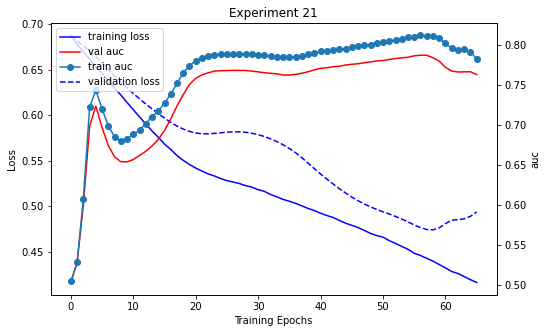

In [200]:
show_results('aggregations_conv_type')

## Aggregations

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
34,True,True,SAGEConv,10,ones,32,None,sum,sum,2,1,1,0.905
31,True,True,SAGEConv,10,ones,32,None,mean,sum,2,1,1,0.904
37,True,True,SAGEConv,10,ones,32,None,max,sum,2,1,1,0.896
22,True,True,SAGEConv,10,random,32,None,mean,sum,2,1,1,0.894
28,True,True,SAGEConv,10,random,32,None,max,sum,2,1,1,0.893
29,True,True,SAGEConv,10,random,32,None,max,max,2,1,1,0.892
25,True,True,SAGEConv,10,random,32,None,sum,sum,2,1,1,0.884
23,True,True,SAGEConv,10,random,32,None,mean,max,2,1,1,0.883
26,True,True,SAGEConv,10,random,32,None,sum,max,2,1,1,0.881
32,True,True,SAGEConv,10,ones,32,None,mean,max,2,1,1,0.873


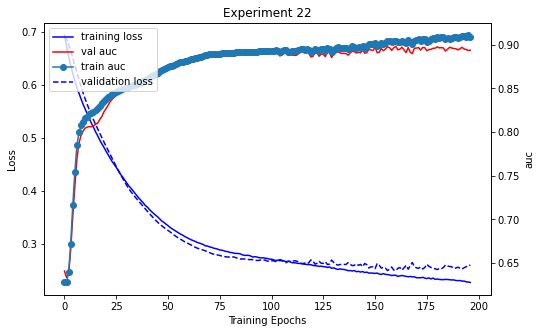

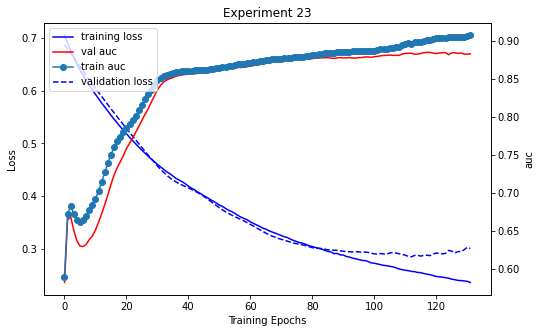

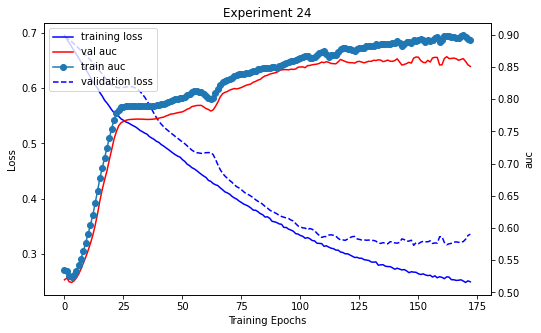

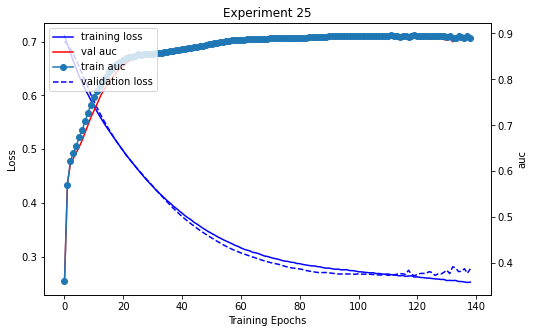

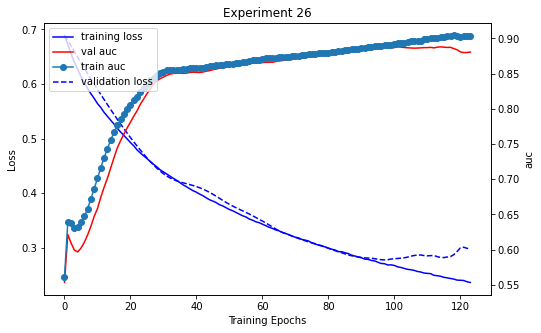

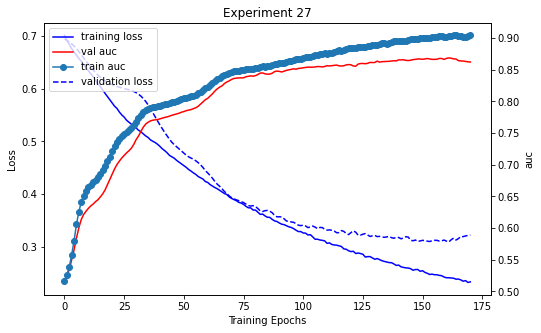

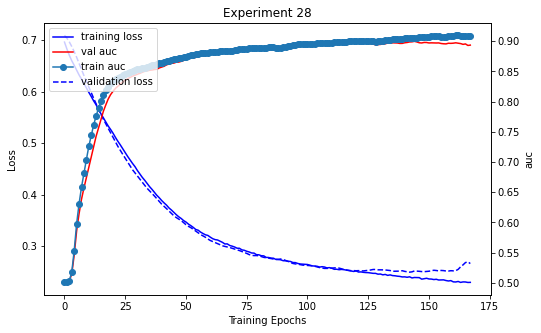

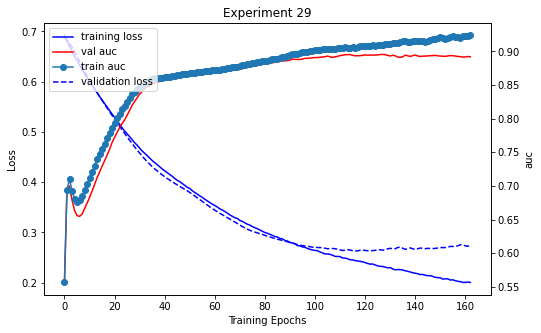

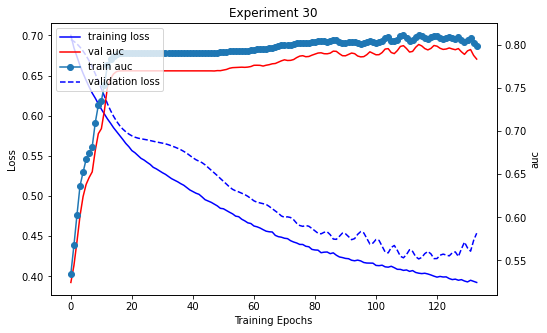

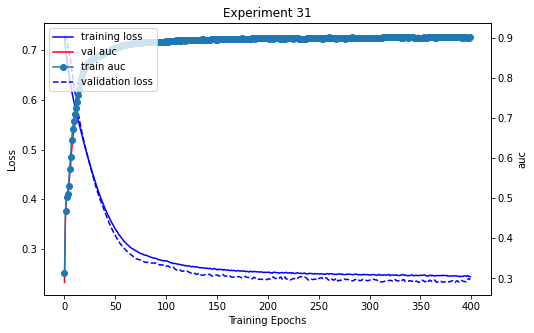

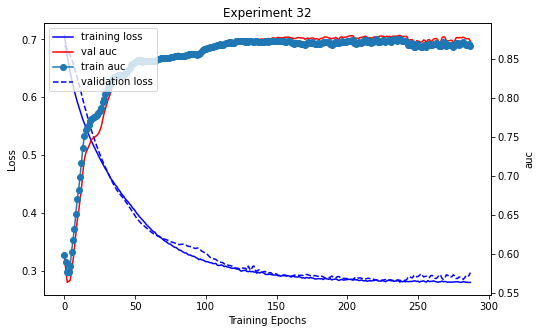

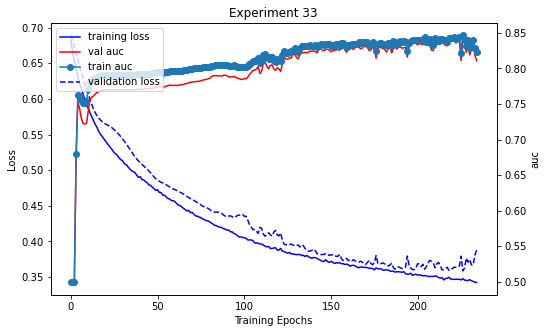

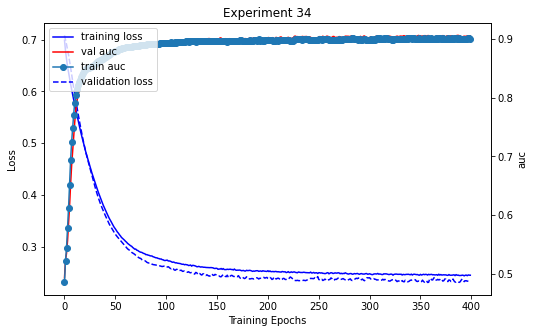

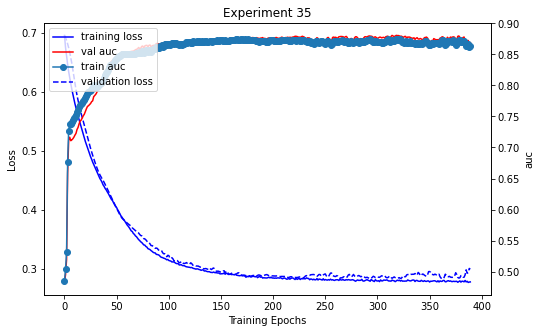

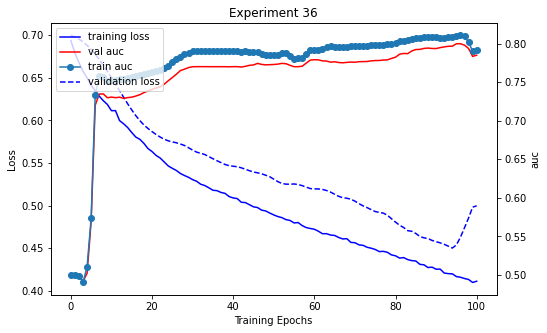

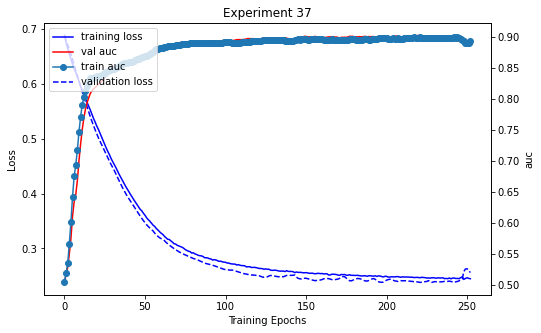

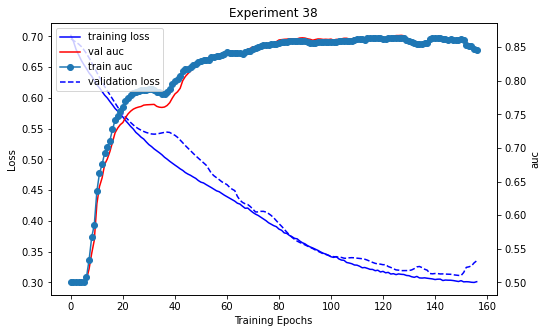

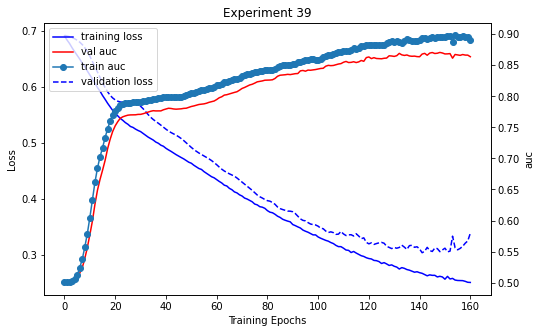

In [144]:
show_results('aggregations_feature_type')

## Connectivity

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
42,True,True,SAGEConv,10,random,32,None,mean,mean,2,1,1,0.858
40,True,True,SAGEConv,10,random,32,skipcat,mean,mean,2,1,1,0.843
41,True,True,SAGEConv,10,random,32,skipsum,mean,mean,2,1,1,0.775


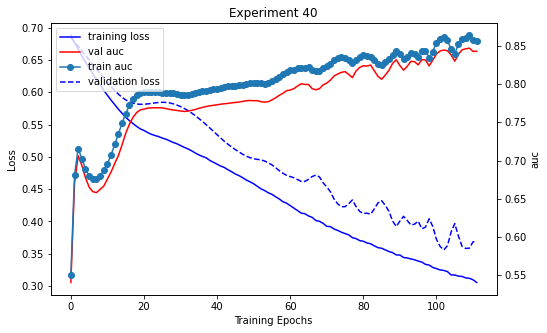

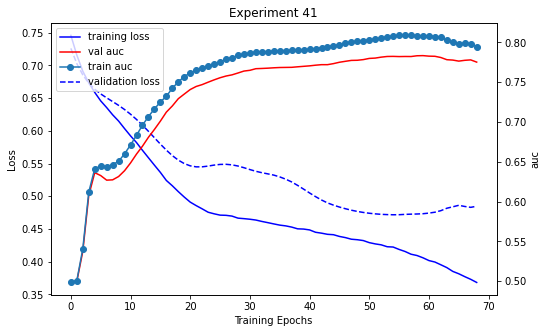

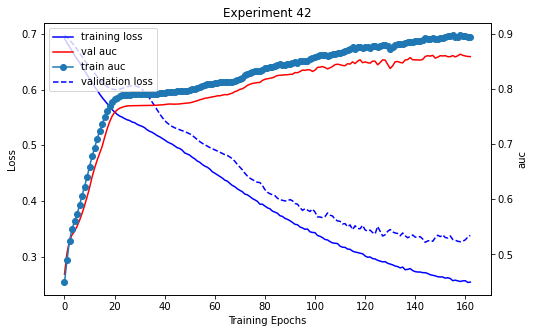

In [147]:
show_results("connectivity")

## L2 norm

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
43,False,True,SAGEConv,10,random,32,None,mean,mean,2,1,1,0.859
44,True,True,SAGEConv,10,random,32,None,mean,mean,1,0,0,0.779


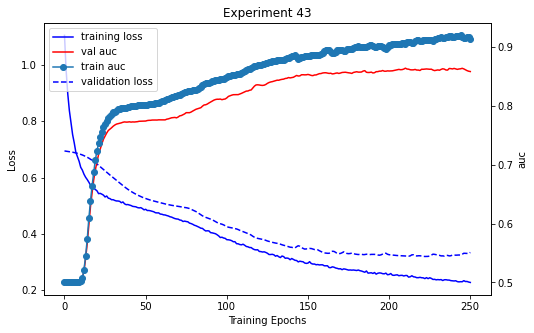

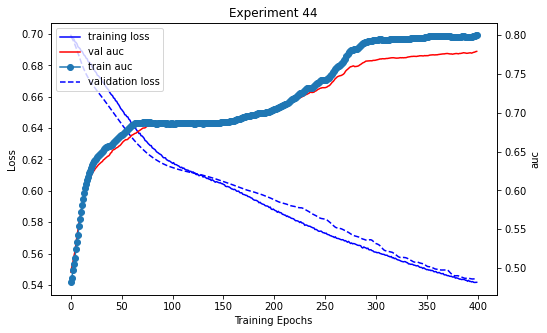

In [148]:
show_results("L2_norm")

## Pre y post

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
48,True,True,SAGEConv,10,random,32,None,mean,mean,1,1,1,0.875
50,True,True,SAGEConv,10,random,32,None,mean,mean,1,2,0,0.872
47,True,True,SAGEConv,10,random,32,None,mean,mean,1,1,0,0.867
65,True,True,SAGEConv,10,random,32,None,mean,mean,3,1,0,0.863
59,True,True,SAGEConv,10,random,32,None,mean,mean,2,2,0,0.861
60,True,True,SAGEConv,10,random,32,None,mean,mean,2,2,1,0.860
71,True,True,SAGEConv,10,random,32,None,mean,mean,2,1,1,0.860
68,True,True,SAGEConv,10,random,32,None,mean,mean,3,2,0,0.857
66,True,True,SAGEConv,10,random,32,None,mean,mean,3,1,1,0.854
56,True,True,SAGEConv,10,random,32,None,mean,mean,2,1,0,0.848


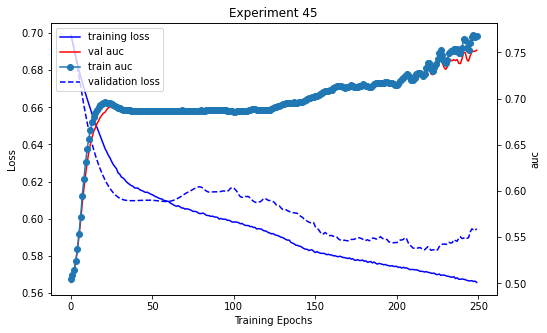

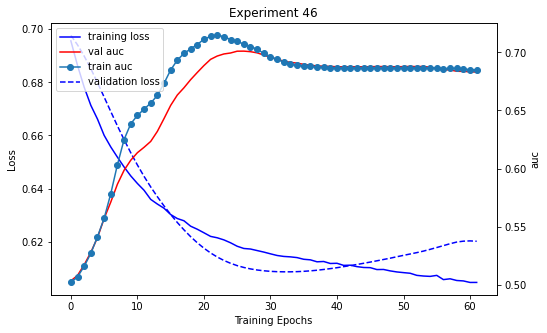

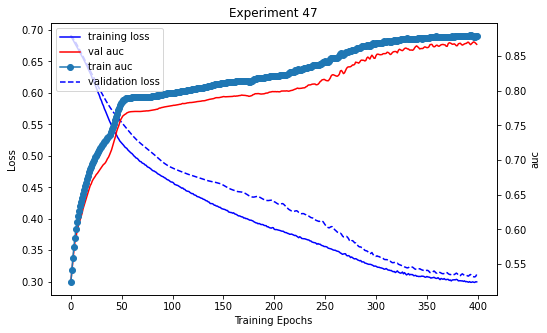

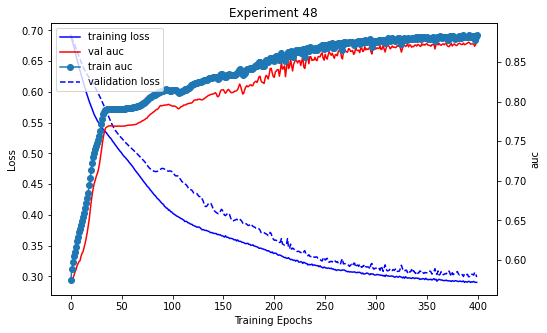

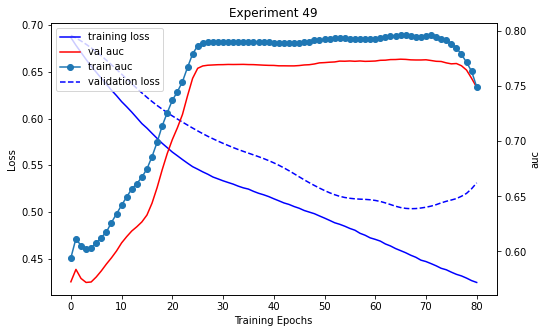

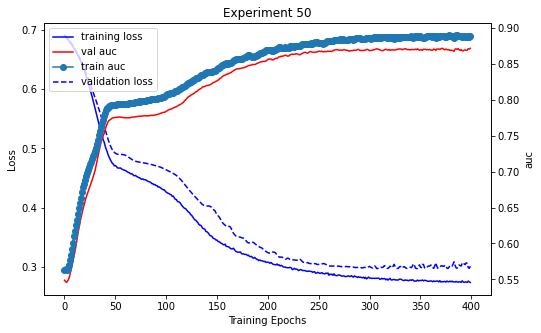

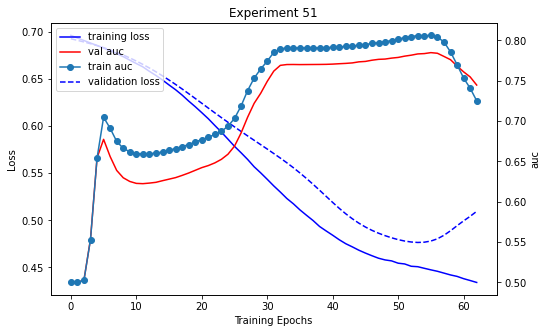

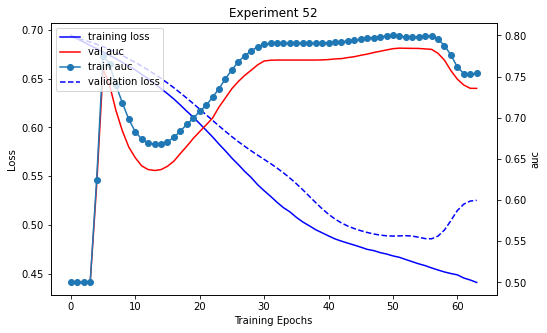

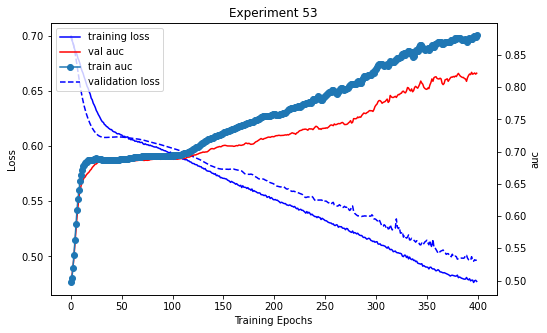

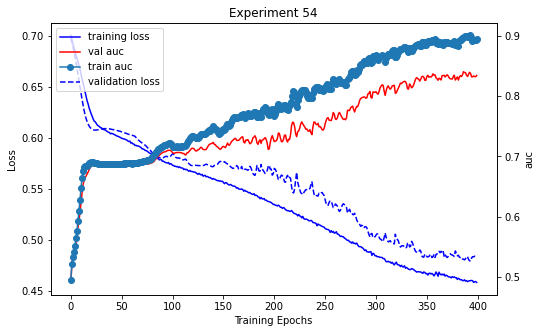

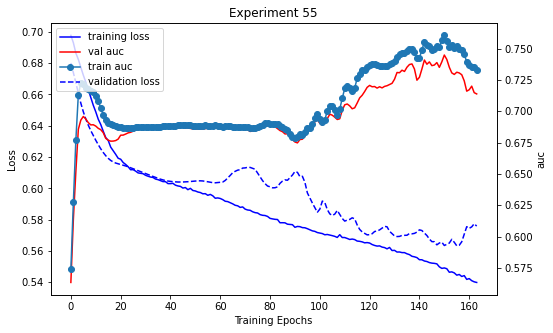

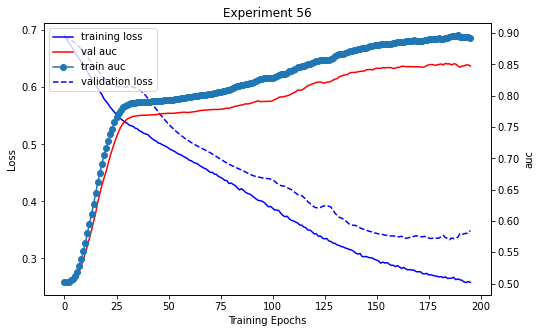

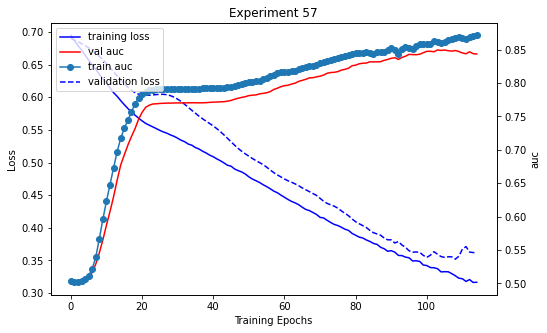

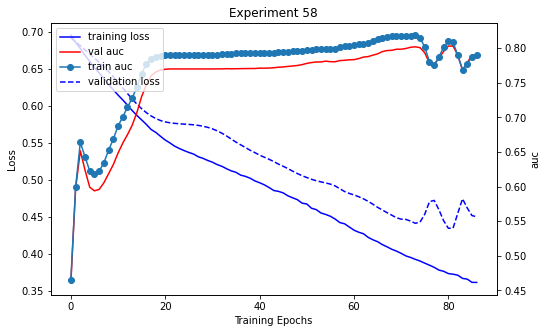

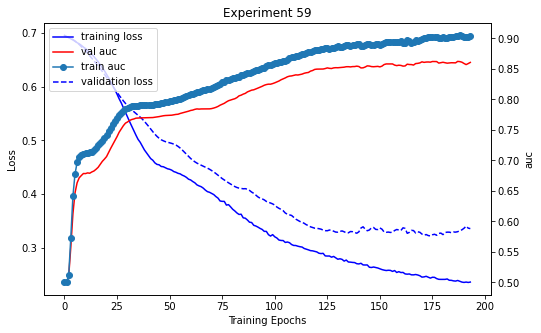

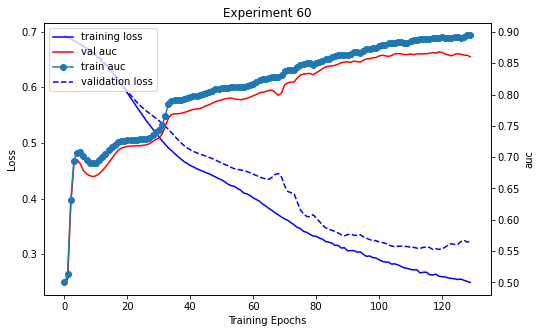

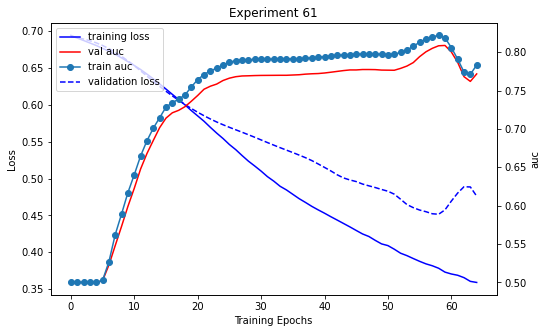

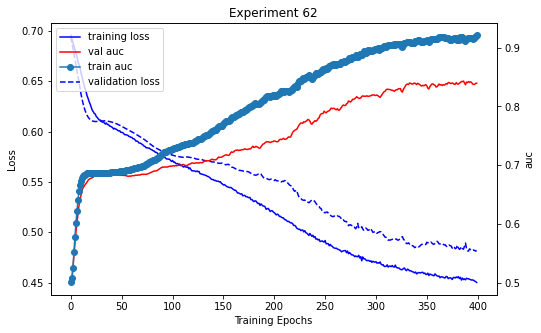

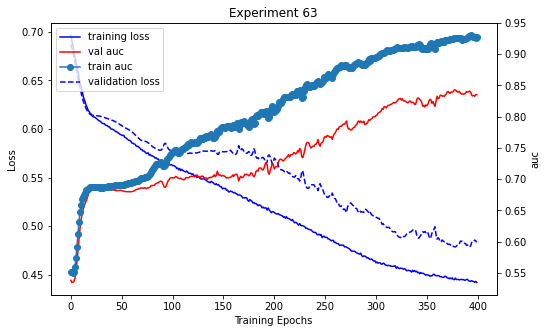

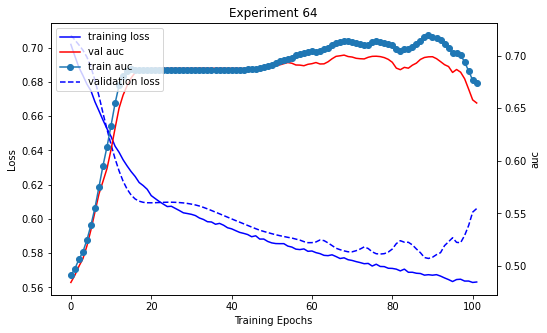

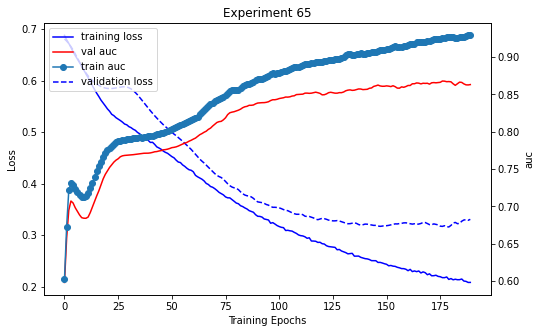

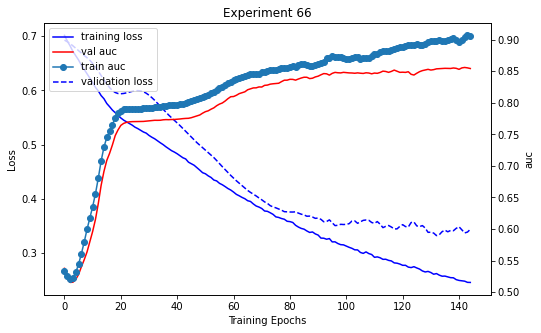

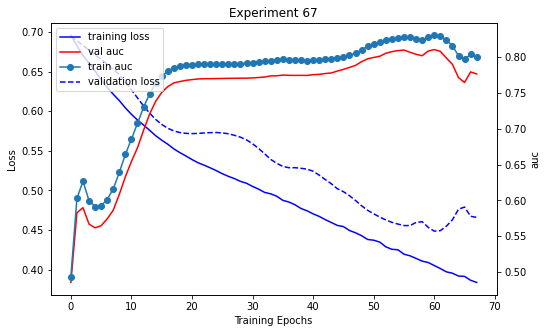

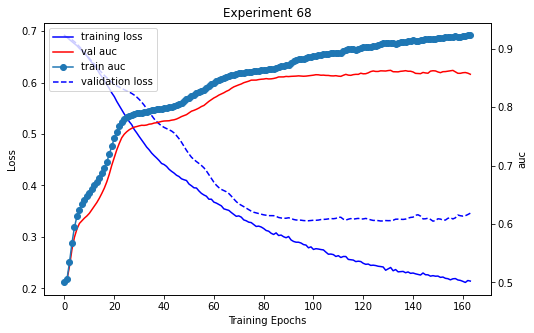

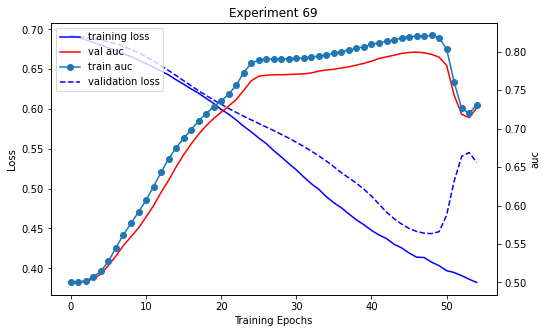

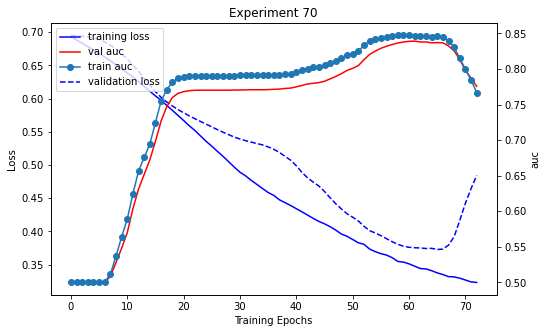

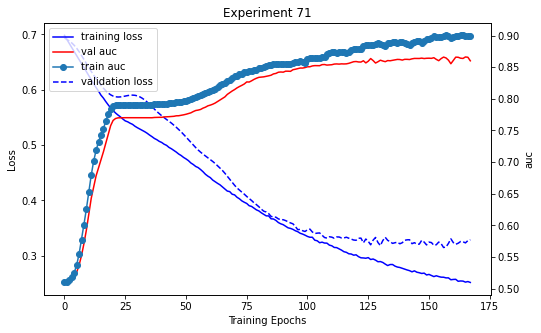

In [149]:
show_results('num_layers')

## Message passing

In [151]:
experiment_index.keys()

dict_keys(['hidden_dim', 'aggregations_conv_type', 'aggregations_feature_type', 'connectivity', 'L2_norm', 'num_layers', 'feature_dim'])

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
72,True,True,SAGEConv,10,ones,32,None,mean,mean,2,1,1,0.802
74,True,True,SAGEConv,50,ones,32,None,mean,mean,2,1,1,0.800
76,True,True,SAGEConv,100,ones,32,None,mean,mean,2,1,1,0.797
73,True,True,SAGEConv,50,random,32,None,mean,mean,2,1,1,0.794
75,True,True,SAGEConv,100,random,32,None,mean,mean,2,1,1,0.742


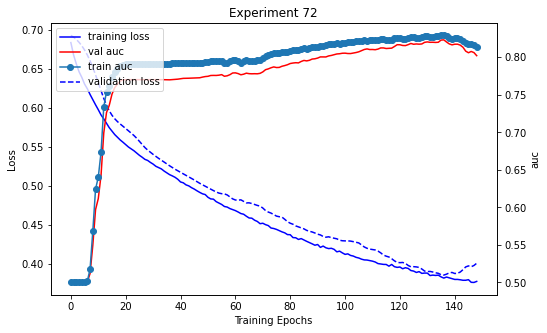

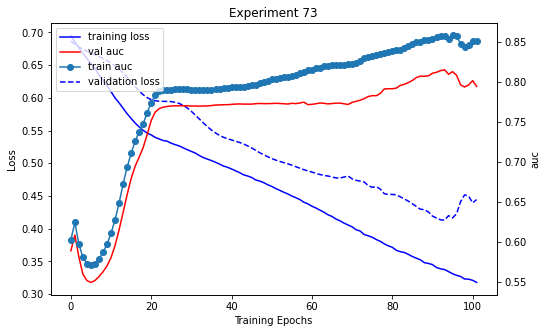

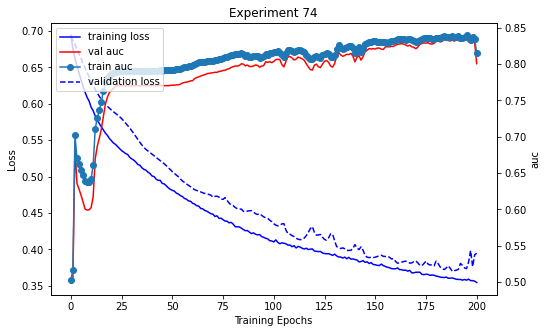

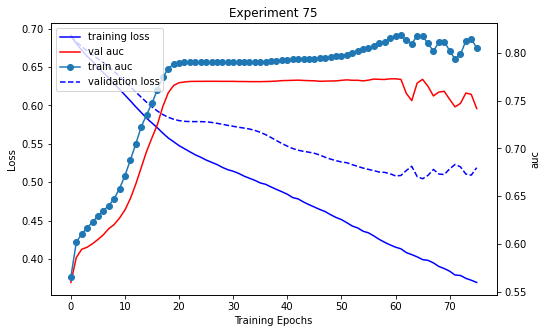

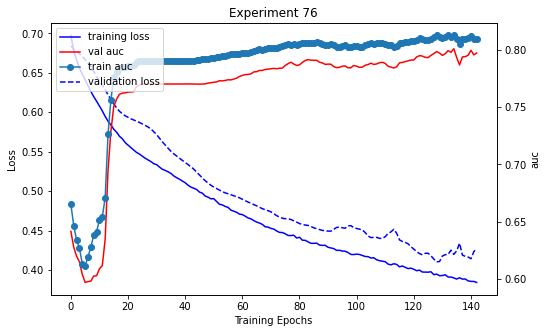

In [167]:
show_results("feature_dim")

## Feature type

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
34,True,True,SAGEConv,50,ones,32,None,mean,sum,2,1,1,0.906
36,True,True,SAGEConv,100,ones,32,None,mean,sum,2,1,1,0.904
32,True,True,SAGEConv,10,ones,32,None,mean,sum,2,1,1,0.899
35,True,True,SAGEConv,100,random,32,None,mean,sum,2,1,1,0.887
33,True,True,SAGEConv,50,random,32,None,mean,sum,2,1,1,0.886
31,True,True,SAGEConv,10,random,32,None,mean,sum,2,1,1,0.882


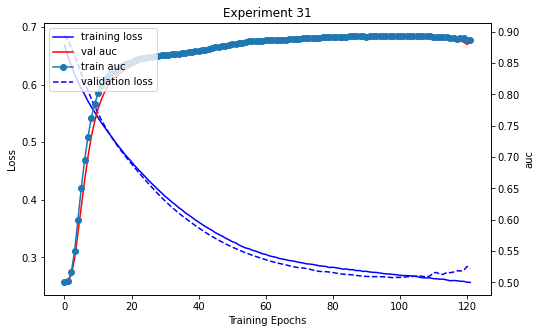

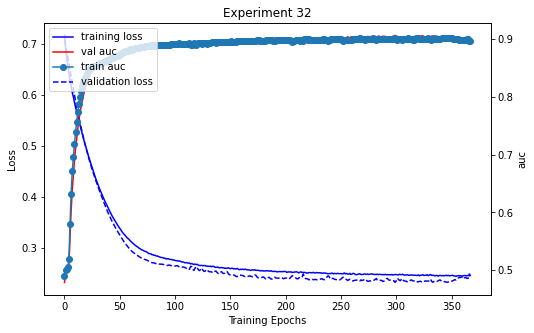

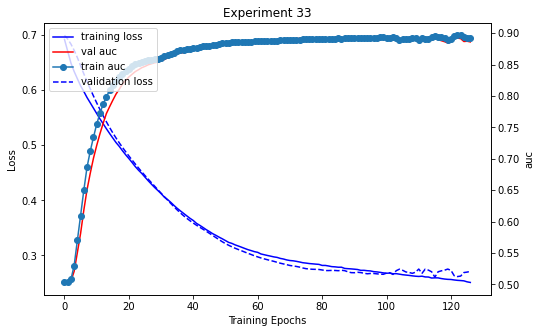

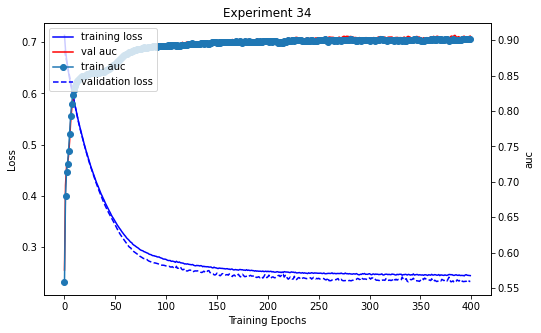

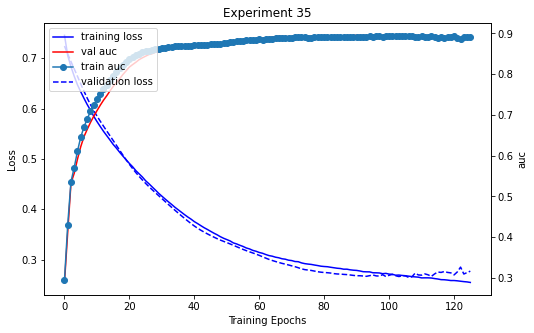

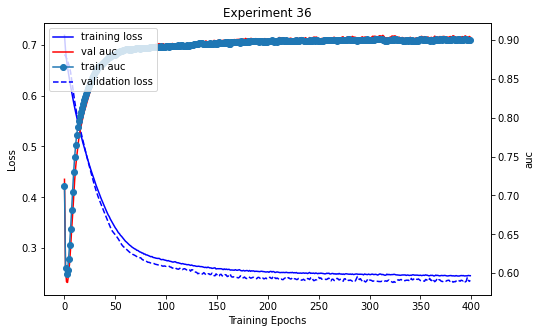

In [66]:
show_results("feature_type")

# Top 5 y worst 5

In [202]:
worst_5 = df.sort_values(by="auc")[:5].round(2)
display(worst_5)

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
64,True,True,SAGEConv,10,random,32,None,mean,mean,3,0,2,0.65
46,True,True,SAGEConv,10,random,32,None,mean,mean,1,0,2,0.68
55,True,True,SAGEConv,10,random,32,None,mean,mean,2,0,2,0.71
2,True,True,SAGEConv,10,random,128,None,mean,mean,2,1,1,0.72
69,True,True,SAGEConv,10,random,32,None,mean,mean,3,2,1,0.73


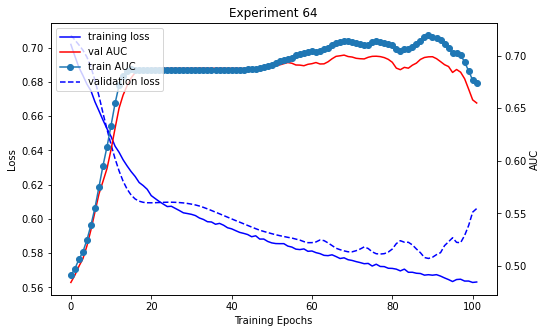

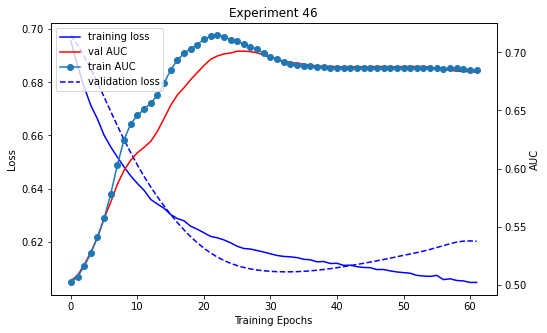

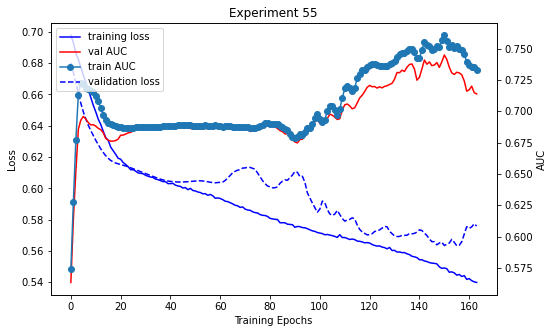

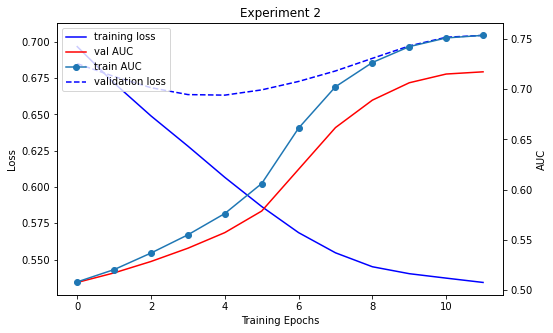

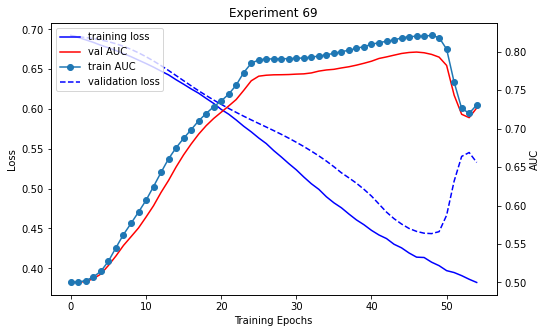

In [180]:
for experiment in worst_5.index.values:
    plot_training_stats(f"Experiment {experiment}",*results.loc[experiment,"curve_data"],"AUC")

In [206]:
top_5 = df.sort_values(by="auc", ascending=False)[:5].round(2)
display(top_5)

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
34,True,True,SAGEConv,10,ones,32,None,sum,sum,2,1,1,0.91
31,True,True,SAGEConv,10,ones,32,None,mean,sum,2,1,1,0.90
37,True,True,SAGEConv,10,ones,32,None,max,sum,2,1,1,0.90
10,True,True,SAGEConv,10,random,32,None,max,sum,2,1,1,0.89
7,True,True,SAGEConv,10,random,32,None,sum,sum,2,1,1,0.89


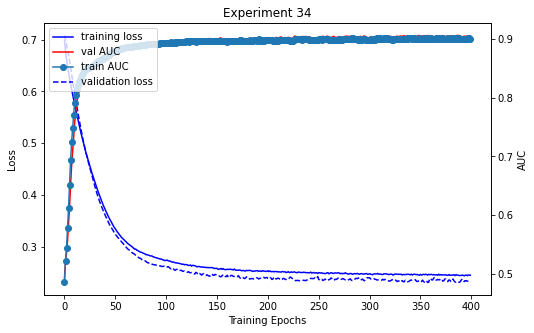

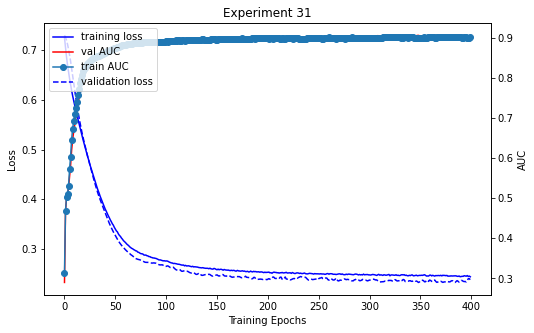

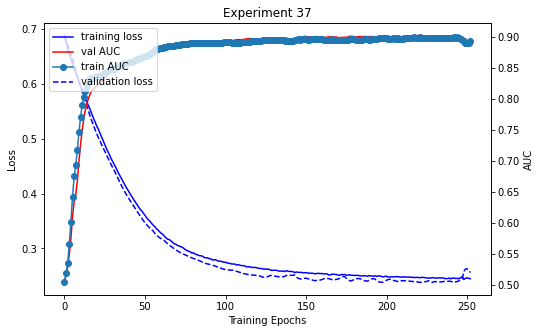

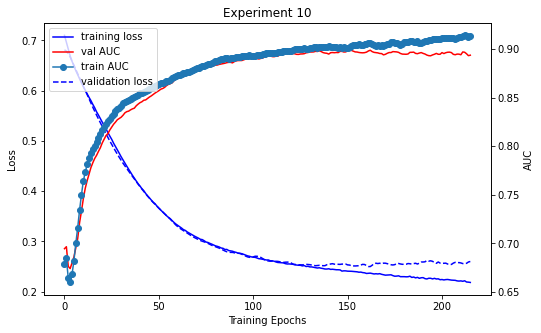

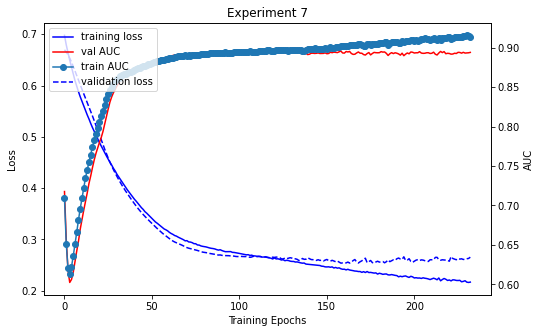

In [182]:
for experiment in top_5.index.values:
    plot_training_stats(f"Experiment {experiment}",*results.loc[experiment,"curve_data"],"AUC")

In [187]:
df[(df.msg_passing_layers == 2)&(df.pre_process_layers == 0)&(df.post_process_layers == 0)]

,L2_norm,batch_norm,conv_type,feature_dim,feature_type,hidden_channels,layer_connectivity,macro_aggregation,micro_aggregation,msg_passing_layers,post_process_layers,pre_process_layers,auc
53,True,True,SAGEConv,10,random,32,None,mean,mean,2,0,0,0.821509


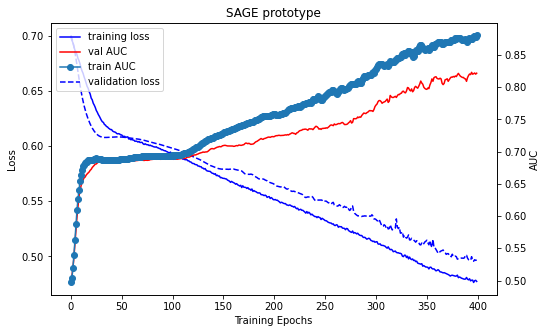

In [188]:
plot_training_stats("SAGE prototype",*results.loc[53,"curve_data"],"AUC")